In [5]:
import sys
import numpy as np
from graphviz import Digraph, Source
from pathlib import Path
from pynini import Weight

sys.path.append(str(Path.home() / 'Code/Python/wynini'))
from wynini import config as wconfig
from wynini import wfst
from wynini.wfst import *

#help(wconfig)

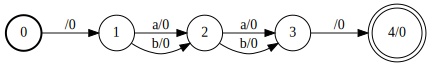

In [6]:
M = braid(2, arc_type='log')
one = Weight('log', 0.0)
M.assign_weights(lambda M, q, t: one)

#M = trellis(2)
#M = ngram(context='left', length=1)
M.draw('M.dot', show_weight_one=True)
M_viz = Source.from_file('M.dot')
M_viz

In [7]:
beta = shortestdistance(M, reverse=True)
beta = np.array([float(w) for w in beta])
print(np.exp(-beta))

[4. 4. 2. 1. 1.]
